### Zadanie 17 — (15p)
Znajdź i pobierz dane dotyczące wypadków samochodowych. Mogą to być np. powiązane zbiory dotyczące UK, zbiór dotyczący `Addis Ababa`.
- $a)$ Wykorzystując algorytm *Apriori* spróbuj wyznaczyć zestawy cech i reguły wskazujące na okoliczności, w jakich dochodzi do wypadków. Rozważ osobno wypadki **lekkie** i **poważne** - do tego podziału możesz wykorzystać więcej niż jedną zmienną.
- $b)$ Dla wybranych zestawów cech wygeneruj wykresy typu *parallel categories diagram* by lepiej zrozumieć zależności między nimi.
- $c)$ Wygeneruj wykres zależności miedzy wartością $support_{min}$ a czasem działania algorytmu, łączną liczbą kandydatów z przycinaniem i bez przycinania (ang. pruning), łączną liczbą kandydatów częstych i maksymalnym rozmiarem zbioru częstego.

In [10]:
import numpy as np
import pandas as pd
import plotly.express as px
import mlxtend
import time
import warnings

from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [11]:
data_full = pd.read_csv("/home/dominik/Studia/Magisterka/M-2-Semestr/AAD/lab5/Addis-Ababa-City/RTA Dataset.csv")
data_clean = pd.read_csv("/home/dominik/Studia/Magisterka/M-2-Semestr/AAD/lab5/Addis-Ababa-City/cleaned.csv")

In [12]:
print(data_full.columns)
print("Num of columnsL", len(data_full.columns))

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')
Num of columnsL 32


In [13]:
print(data_clean.columns)
print("Num of columnsL", len(data_clean.columns))
print(data_clean.head())

Index(['Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
       'Vehicle_driver_relation', 'Driving_experience', 'Lanes_or_Medians',
       'Types_of_Junction', 'Road_surface_type', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision', 'Vehicle_movement',
       'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity'],
      dtype='object')
Num of columnsL 15
  Age_band_of_driver Sex_of_driver   Educational_level  \
0              18-30          Male   Above high school   
1              31-50          Male  Junior high school   
2              18-30          Male  Junior high school   
3              18-30          Male  Junior high school   
4              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience   Lanes_or_Medians  \
0                Employee              1-2yr            Unknown   
1                Employee         Above 10yr  Undivided Two way   
2                Employee              1-2yr          

In [14]:
columns_diff = set(data_full.columns) - set(data_clean.columns)
print(columns_diff)

{'Fitness_of_casuality', 'Number_of_casualties', 'Casualty_severity', 'Road_allignment', 'Area_accident_occured', 'Defect_of_vehicle', 'Service_year_of_vehicle', 'Sex_of_casualty', 'Type_of_vehicle', 'Day_of_week', 'Age_band_of_casualty', 'Owner_of_vehicle', 'Casualty_class', 'Work_of_casuality', 'Road_surface_conditions', 'Number_of_vehicles_involved', 'Time'}


In [15]:
print("Before removing \'Unknown\':", data_clean.shape)

data_clean = data_clean[~data_clean.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1)]
data_clean = data_clean.dropna()

print("After: removing \'Unknown\'", data_clean.shape)

data_clean.head()

Before removing 'Unknown': (12316, 15)
After: removing 'Unknown' (7498, 15)


,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
7,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,U-Turn,Not a Pedestrian,No priority to vehicle,2


In [16]:
# data_clean['Accident_severity'] = data_clean['Accident_severity'].replace({0: 'Fatal Injury', 1: 'Serious Injury', 2: 'Slight Injury', })
# print(data_clean['Accident_severity'].head())

# severity_counts = data_clean['Accident_severity'].value_counts(normalize=True) * 100
# print(severity_counts)

df_serious = data_clean[data_clean['Accident_severity'] < 2]
df_serious = df_serious.drop(columns=['Accident_severity'])
df_serious = df_serious.dropna()
df_serious.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left
9,18-30,Male,Junior high school,Employee,1-2yr,Undivided Two way,Y Shape,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,U-Turn,Not a Pedestrian,Moving Backward
10,18-30,Male,Above high school,Owner,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with animals,Turnover,Not a Pedestrian,Changing lane to the left
11,31-50,Male,Above high school,Employee,No Licence,Undivided Two way,No junction,Earth roads,Daylight,Normal,Collision with animals,Going straight,Not a Pedestrian,No priority to pedestrian
14,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Collision with animals,Going straight,Not a Pedestrian,No distancing


In [17]:
df_slight = data_clean[data_clean['Accident_severity'] == 2]
df_slight = df_slight.drop(columns=['Accident_severity'])
df_slight = df_slight.dropna()
df_slight.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking
7,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,U-Turn,Not a Pedestrian,No priority to vehicle
8,18-30,Male,Junior high school,Employee,Above 10yr,other,Y Shape,Earth roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Crossing from driver's nearside,Changing lane to the right


In [18]:
df_serious = pd.get_dummies(df_serious)
df_slight = pd.get_dummies(df_slight)

df_serious

,Age_band_of_driver_18-30,Age_band_of_driver_31-50,Age_band_of_driver_Over 51,Age_band_of_driver_Under 18,Sex_of_driver_Female,Sex_of_driver_Male,Educational_level_Above high school,Educational_level_Elementary school,Educational_level_High school,Educational_level_Illiterate,...,Cause_of_accident_Moving Backward,Cause_of_accident_No distancing,Cause_of_accident_No priority to pedestrian,Cause_of_accident_No priority to vehicle,Cause_of_accident_Other,Cause_of_accident_Overloading,Cause_of_accident_Overspeed,Cause_of_accident_Overtaking,Cause_of_accident_Overturning,Cause_of_accident_Turnover
2,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,True,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
10,True,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,False,True,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
14,False,True,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12271,False,True,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
12288,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
12300,False,True,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
12302,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


#### a) Analiza wypadków ciężkich (serious, fatal)

In [19]:
# uruchamiamy Apriori 
min_support = 0.03 # analizujemy relatywnie mały zbior
frequent_itemsets = apriori(df_serious, min_support, use_colnames=True)

# dodajemy kolumnę z długością każej listy
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets.sort_values(by=['support'], ascending=False)


,support,itemsets,length
4,0.984784,(Sex_of_driver_Male),1
40,0.939983,(Pedestrian_movement_Not a Pedestrian),1
25,0.931530,(Road_surface_type_Asphalt roads),1
181,0.924768,"(Pedestrian_movement_Not a Pedestrian, Sex_of_...",2
166,0.916314,"(Road_surface_type_Asphalt roads, Sex_of_drive...",2
...,...,...,...
216,0.030431,"(Educational_level_High school, Types_of_Junct...",2
26059,0.030431,"(Pedestrian_movement_Not a Pedestrian, Vehicle...",6
26057,0.030431,"(Lanes_or_Medians_other, Vehicle_driver_relati...",6
26187,0.030431,"(Vehicle_movement_Reversing, Light_conditions_...",6


In [34]:
print(frequent_itemsets.shape[0])
print(frequent_itemsets['length'].max())
print(frequent_itemsets['itemsets'].head())

33405
10
0       (Age_band_of_driver_18-30)
1       (Age_band_of_driver_31-50)
2     (Age_band_of_driver_Over 51)
3    (Age_band_of_driver_Under 18)
4             (Sex_of_driver_Male)
Name: itemsets, dtype: object


In [28]:
# przykładowe zapytanie
print(frequent_itemsets[ 
    (frequent_itemsets['length'] == 10) 
].sort_values("support", ascending=False))

        support                                           itemsets  length
33401  0.069315  (Light_conditions_Daylight, Pedestrian_movemen...      10
33395  0.061708  (Light_conditions_Daylight, Pedestrian_movemen...      10
33385  0.056636  (Light_conditions_Daylight, Pedestrian_movemen...      10
33399  0.051564  (Light_conditions_Daylight, Pedestrian_movemen...      10
33400  0.048183  (Light_conditions_Daylight, Pedestrian_movemen...      10
33377  0.048183  (Age_band_of_driver_18-30, Light_conditions_Da...      10
33403  0.043111  (Light_conditions_Daylight, Pedestrian_movemen...      10
33390  0.040575  (Light_conditions_Daylight, Pedestrian_movemen...      10
33392  0.040575  (Light_conditions_Daylight, Pedestrian_movemen...      10
33391  0.039730  (Light_conditions_Daylight, Pedestrian_movemen...      10
33386  0.036348  (Light_conditions_Daylight, Pedestrian_movemen...      10
33389  0.036348  (Driving_experience_5-10yr, Light_conditions_D...      10
33394  0.035503  (Pedestr

In [30]:
# lift = 1, A i B są niezależne (kupno A nie ma wpływu na kupno B)
# lift > 1, A i B są pozytywnie skorelowane (klienci często kupują A i B razem)
# lift < 1, A i B są negatywnie skorelowane (klienci raczej nie kupują A i B razem)

rules = association_rules(frequent_itemsets,
                          num_itemsets = 7500, 
                          metric="lift", 
                          min_threshold=2)

rules.sort_values("confidence",ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,"(Weather_conditions_Raining, Pedestrian_moveme...","(Light_conditions_Darkness - lights lit, Vehic...",0.061708,0.229924,0.030431,0.493151,2.144843,1.0,0.016243,1.519339,0.568869,0.116505,0.341819,0.312752
3,"(Weather_conditions_Raining, Vehicle_movement_...","(Light_conditions_Darkness - lights lit, Vehic...",0.066779,0.229924,0.031276,0.468354,2.036997,1.0,0.015922,1.448476,0.545510,0.117834,0.309619,0.302192
33,"(Sex_of_driver_Male, Weather_conditions_Rainin...","(Light_conditions_Darkness - lights lit, Vehic...",0.065089,0.229924,0.030431,0.467532,2.033422,1.0,0.015466,1.446240,0.543601,0.115016,0.308552,0.299943
39,"(Weather_conditions_Raining, Pedestrian_moveme...","(Sex_of_driver_Male, Light_conditions_Darkness...",0.065089,0.224852,0.030431,0.467532,2.079289,1.0,0.015796,1.455766,0.555204,0.117264,0.313076,0.301435
14,"(Weather_conditions_Raining, Pedestrian_moveme...","(Light_conditions_Darkness - lights lit, Vehic...",0.065089,0.229924,0.030431,0.467532,2.033422,1.0,0.015466,1.446240,0.543601,0.115016,0.308552,0.299943


#### a) Analiza wypadków lekkich

In [12]:
# uruchamiamy Apriori 
min_support = 0.03 # analizujemy relatywnie mały zbior
frequent_itemsets = apriori(df_slight, min_support, use_colnames=True)

# dodajemy kolumnę z długością każej listy
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(frequent_itemsets.sort_values(by=['support'], ascending=False))

,support,itemsets,length
4,0.993191,(Sex_of_driver_Male),1
40,0.949960,(Pedestrian_movement_Not a Pedestrian),1
182,0.943310,"(Pedestrian_movement_Not a Pedestrian, Sex_of_...",2
25,0.933333,(Road_surface_type_Asphalt roads),1
167,0.926524,"(Road_surface_type_Asphalt roads, Sex_of_drive...",2
...,...,...,...
32640,0.030087,"(Light_conditions_Daylight, Sex_of_driver_Male...",8
32644,0.030087,"(Light_conditions_Daylight, Sex_of_driver_Male...",8
17104,0.030087,"(Weather_conditions_Normal, Vehicle_driver_rel...",5
17235,0.030087,"(Vehicle_driver_relation_Employee, Pedestrian_...",5


In [16]:
rules = association_rules(frequent_itemsets,
                          num_itemsets = 7500 - 2, 
                          metric="lift", 
                          min_threshold=1.3)

rules.sort_values("confidence",ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2430,"(Vehicle_movement_Going straight, Light_condit...","(Types_of_Junction_Y Shape, Weather_conditions...",0.069834,0.345051,0.031671,0.453515,1.314339,1.0,0.007574,1.198474,0.257117,0.082645,0.165606,0.272650
2926,"(Vehicle_movement_Going straight, Light_condit...","(Types_of_Junction_Y Shape, Weather_conditions...",0.069200,0.345051,0.031354,0.453089,1.313106,1.0,0.007476,1.197542,0.256174,0.081886,0.164956,0.271978
1318,"(Vehicle_movement_Going straight, Light_condit...","(Types_of_Junction_Y Shape, Weather_conditions...",0.074743,0.345051,0.033571,0.449153,1.301697,1.0,0.007781,1.188983,0.250495,0.086921,0.158945,0.273222
2929,"(Vehicle_movement_Going straight, Light_condit...","(Types_of_Junction_Y Shape, Weather_conditions...",0.069834,0.342835,0.031354,0.448980,1.309610,1.0,0.007413,1.192634,0.254163,0.082226,0.161520,0.270217
2178,"(Vehicle_movement_Going straight, Light_condit...","(Types_of_Junction_Y Shape, Weather_conditions...",0.074109,0.345051,0.033254,0.448718,1.300438,1.0,0.007683,1.188046,0.249520,0.086172,0.158282,0.272546


#### b) *Parrallel categories diagram*

In [9]:
data_clean['Accident_severity'] = data_clean['Accident_severity'].astype('category')
data_clean = pd.get_dummies(data_clean)
data_clean.head()

,Age_band_of_driver_18-30,Age_band_of_driver_31-50,Age_band_of_driver_Over 51,Age_band_of_driver_Under 18,Sex_of_driver_Female,Sex_of_driver_Male,Educational_level_Above high school,Educational_level_Elementary school,Educational_level_High school,Educational_level_Illiterate,...,Cause_of_accident_No priority to vehicle,Cause_of_accident_Other,Cause_of_accident_Overloading,Cause_of_accident_Overspeed,Cause_of_accident_Overtaking,Cause_of_accident_Overturning,Cause_of_accident_Turnover,Accident_severity_0,Accident_severity_1,Accident_severity_2
1,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
7,True,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [ ]:
print(data_clean.columns)
for col in data_clean.columns:
    print(col)

In [23]:
# Wybrane cechy do wizualizacji
selected_columns = ['Accident_severity_1', 'Weather_conditions_Normal', 'Sex_of_driver_Male']
visual_data = data_clean[selected_columns]

# Tworzenie wykresu typu parallel categories diagram
fig = px.parallel_categories(
    visual_data,
    dimensions=selected_columns,
)

# Wyświetlenie wykresu
fig.show()

In [24]:
# Wybrane cechy do wizualizacji
selected_columns = ['Accident_severity_2', 'Weather_conditions_Normal', 'Sex_of_driver_Male']
visual_data = data_clean[selected_columns]

# Tworzenie wykresu typu parallel categories diagram
fig = px.parallel_categories(
    visual_data,
    dimensions=selected_columns,
)

# Wyświetlenie wykresu
fig.show()

In [27]:
# Wybrane cechy do wizualizacji
selected_columns = ['Cause_of_accident_Overtaking', 'Accident_severity_2']
visual_data = data_clean[selected_columns]

# Tworzenie wykresu typu parallel categories diagram
fig = px.parallel_categories(
    visual_data,
    dimensions=selected_columns,
)

# Wyświetlenie wykresu
fig.show()

In [28]:
# Wybrane cechy do wizualizacji
selected_columns = ['Accident_severity_1', 'Weather_conditions_Raining', 'Light_conditions_Darkness - lights lit']
visual_data = data_clean[selected_columns]

# Tworzenie wykresu typu parallel categories diagram
fig = px.parallel_categories(
    visual_data,
    dimensions=selected_columns,
)

# Wyświetlenie wykresu
fig.show()

$c)$ Wygeneruj wykres zależności miedzy wartością $support_{min}$ a czasem działania algorytmu, łączną liczbą kandydatów z przycinaniem i bez przycinania (ang. pruning), łączną liczbą kandydatów częstych i maksymalnym rozmiarem zbioru częstego.

In [66]:
import numpy as np
import pandas as pd
import plotly.express as px
import mlxtend
import time
import warnings

from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from copy import deepcopy
from collections import defaultdict


warnings.filterwarnings('ignore', category=DeprecationWarning)

In [75]:
def my_apriori(data, min_support, pruning=False):
    """
    Algorytm Apriori bez pruningu dla danych zakodowanych jako one-hot.
    
    Parameters:
        data (pd.DataFrame): Dane wejściowe w formacie one-hot (kolumny to cechy, wartości 0/1).
        min_support (float): Minimalne wsparcie (od 0 do 1).
    
    Returns:
        frequent_itemsets (dict): Słownik z kluczami jako zbiory częste i wartościami jako ich wsparcie.
    """
    def calculate_support(itemset, data):
        """Oblicz wsparcie dla danego zbioru cech."""
        mask = data[itemset].all(axis=1)  # Sprawdzamy, gdzie wszystkie cechy w zbiorze są równe 1
        return mask.sum() / len(data)

    # Krok 1: Tworzenie początkowych zbiorów (C1)
    columns = data.columns
    num_transactions = len(data)
    L1 = [frozenset([col]) for col in columns if calculate_support([col], data) >= min_support]

    frequent_itemsets = L1  # Zapisujemy wszystkie zbiory częste
    current_L = list(L1)  # Zaczynamy od zbiorów 1-elementowych

    k = 2
    while current_L:
        print(f"Krok {k-1}: {len(current_L)} zbiorów {k-1}-elementowych")
        
        # Krok 2: Generowanie kandydatów (Ck)
        candidate_itemsets = [frozenset(set1.union(set2)) 
                              for i, set1 in enumerate(current_L) 
                              for set2 in current_L[i+1:] 
                              if len(set1.union(set2)) == k]
        
        # Usuwanie duplikatów
        candidate_itemsets = list(set(candidate_itemsets))
        
        previous_L = deepcopy(current_L)
        # Krok 3: Filtracja według minimalnego wsparcia
        current_L = [itemset for itemset in candidate_itemsets if calculate_support(itemset, data) >= min_support]
        
        if pruning:
            # Pruning
            current_L = [itemset for itemset in current_L 
                         if all([(frozenset(combo) in previous_L) for combo in combinations(itemset, k-1)])
                        # if all([(calculate_support(combo, data) >= min_support) for combo in combinations(itemset, k-1)]) 
                        ]

        # Dodajemy bieżące zbiory częste do wyniku
        frequent_itemsets.extend(current_L)

        k += 1  # Zwiększamy rozmiar zbioru


    return frequent_itemsets


In [32]:
data_clean = pd.read_csv("/home/dominik/Studia/Magisterka/M-2-Semestr/AAD/lab5/Addis-Ababa-City/cleaned.csv")

data_clean = data_clean[~data_clean.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1)]
data_clean = data_clean.dropna()

data_clean['Accident_severity'] = data_clean['Accident_severity'].astype('category')
data_clean = pd.get_dummies(data_clean)

In [40]:
supports = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]

times = []
num_candidates_pruned = []
frequent_candidates_num = []
max_frequent_set = []

for support in supports:
    start_time = time.time()
    freq_itemsets = apriori(data_clean, min_support=support, use_colnames=True)
    elapsed_time = time.time() - start_time

    times.append(elapsed_time)
    # Łączna liczba zestawów częstych
    frequent_candidates_num.append(freq_itemsets.shape[0])
    # Maksymalny rozmiar zestawu częstego
    max_frequent_set.append(freq_itemsets['itemsets'].apply(lambda x: len(x)).max())


In [59]:
test_itemset = my_apriori(data_clean, min_support=0.1)
print(len(test_itemset))

Krok 1: 35 zbiorów 1-elementowych
Krok 2: 262 zbiorów 2-elementowych
Krok 3: 891 zbiorów 3-elementowych
Krok 4: 1746 zbiorów 4-elementowych
Krok 5: 2162 zbiorów 5-elementowych
Krok 6: 1776 zbiorów 6-elementowych
Krok 7: 907 zbiorów 7-elementowych
Krok 8: 231 zbiorów 8-elementowych
Krok 9: 25 zbiorów 9-elementowych
Krok 10: 1 zbiorów 10-elementowych
8036


In [61]:
num_candidates_unpruned = []

for support in supports: 
    # Liczba zestawów bez przycinania
    print(f"Support: {support}")
    num_candidates_unpruned.append(len(my_apriori(data_clean, support)))

print(num_candidates_unpruned)

Support: 0.03
Krok 1: 52 zbiorów 1-elementowych
Krok 2: 605 zbiorów 2-elementowych
Krok 3: 3055 zbiorów 3-elementowych
Krok 4: 8558 zbiorów 4-elementowych
Krok 5: 14575 zbiorów 5-elementowych
Krok 6: 15927 zbiorów 6-elementowych
Krok 7: 11481 zbiorów 7-elementowych
Krok 8: 5441 zbiorów 8-elementowych
Krok 9: 1623 zbiorów 9-elementowych
Krok 10: 260 zbiorów 10-elementowych
Krok 11: 14 zbiorów 11-elementowych
Support: 0.04
Krok 1: 47 zbiorów 1-elementowych
Krok 2: 508 zbiorów 2-elementowych
Krok 3: 2433 zbiorów 3-elementowych
Krok 4: 6257 zbiorów 4-elementowych
Krok 5: 9789 zbiorów 5-elementowych
Krok 6: 9932 zbiorów 6-elementowych
Krok 7: 6623 zbiorów 7-elementowych
Krok 8: 2810 zbiorów 8-elementowych
Krok 9: 689 zbiorów 9-elementowych
Krok 10: 90 zbiorów 10-elementowych
Krok 11: 6 zbiorów 11-elementowych
Support: 0.05
Krok 1: 44 zbiorów 1-elementowych
Krok 2: 454 zbiorów 2-elementowych
Krok 3: 1990 zbiorów 3-elementowych
Krok 4: 4741 zbiorów 4-elementowych
Krok 5: 7008 zbiorów 5-elemen

In [76]:
# Liczba zestawów po przycinaniu
num_candidates_pruned = []

for support in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]: 
    print(f"Support: {support}")
    num = len(my_apriori(data_clean, support, pruning=True))
    print("sum: ", num)
    num_candidates_pruned.append(num)

print(num_candidates_pruned)

Support: 0.1
Krok 1: 35 zbiorów 1-elementowych
Pruning
Krok 2: 262 zbiorów 2-elementowych
Pruning
Krok 3: 891 zbiorów 3-elementowych
Pruning
Krok 4: 1746 zbiorów 4-elementowych
Pruning
Krok 5: 2162 zbiorów 5-elementowych
Pruning
Krok 6: 1776 zbiorów 6-elementowych
Pruning
Krok 7: 907 zbiorów 7-elementowych
Pruning
Krok 8: 231 zbiorów 8-elementowych
Pruning
Krok 9: 25 zbiorów 9-elementowych
Pruning
Krok 10: 1 zbiorów 10-elementowych
Pruning
sum:  8036
Support: 0.2
Krok 1: 19 zbiorów 1-elementowych
Pruning
Krok 2: 123 zbiorów 2-elementowych
Pruning
Krok 3: 362 zbiorów 3-elementowych
Pruning
Krok 4: 559 zbiorów 4-elementowych
Pruning
Krok 5: 473 zbiorów 5-elementowych
Pruning
Krok 6: 252 zbiorów 6-elementowych
Pruning
Krok 7: 98 zbiorów 7-elementowych
Pruning
Krok 8: 22 zbiorów 8-elementowych
Pruning
sum:  1908
Support: 0.3
Krok 1: 16 zbiorów 1-elementowych
Pruning
Krok 2: 75 zbiorów 2-elementowych
Pruning
Krok 3: 163 zbiorów 3-elementowych
Pruning
Krok 4: 219 zbiorów 4-elementowych
Pruni

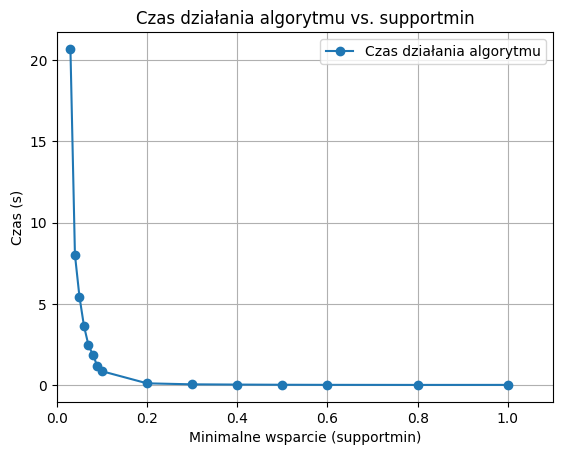

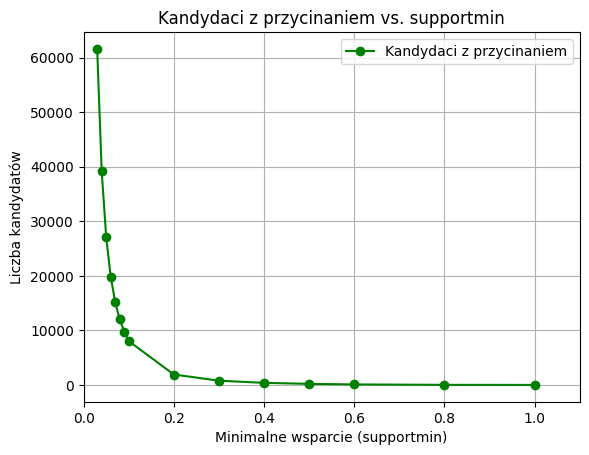

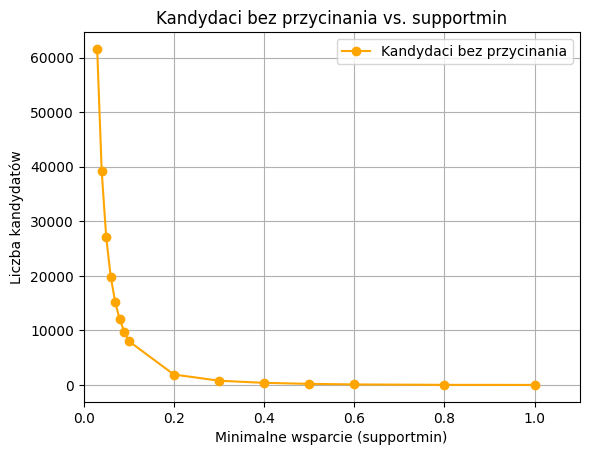

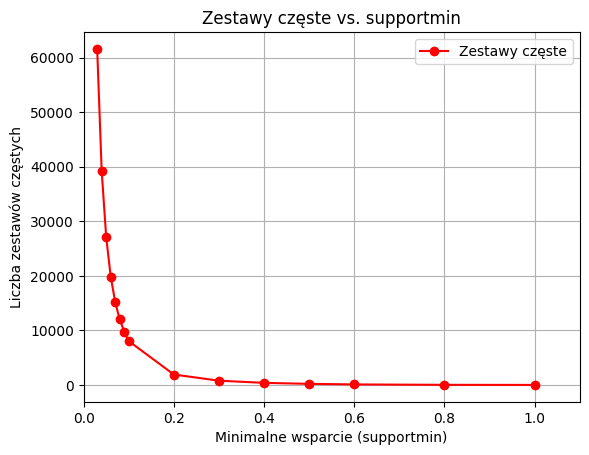

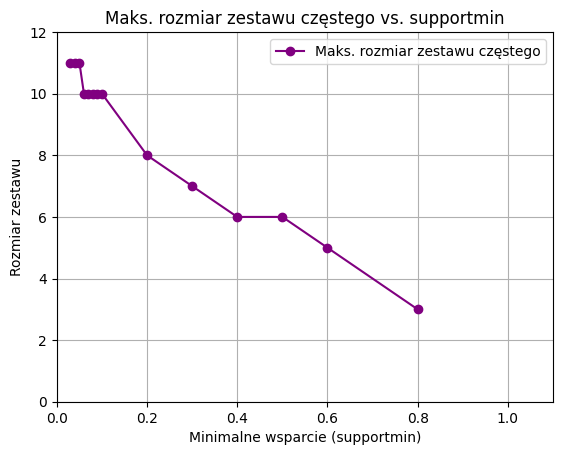

In [62]:

# Wykres 1: Czas działania algorytmu
# plt.subplot(3, 2, 1)
plt.plot(supports, times, marker='o', label='Czas działania algorytmu')
plt.xlim(0, 1.1)
plt.xlabel('Minimalne wsparcie (supportmin)')
plt.ylabel('Czas (s)')
plt.title('Czas działania algorytmu vs. supportmin')
plt.grid(True)
plt.legend()
plt.show()

# Wykres 2: Liczba kandydatów po przycinaniu
# plt.subplot(3, 2, 2)
plt.plot(supports, num_candidates_pruned, marker='o', label='Kandydaci z przycinaniem', color='green')
plt.xlim(0, 1.1)
plt.xlabel('Minimalne wsparcie (supportmin)')
plt.ylabel('Liczba kandydatów')
plt.title('Kandydaci z przycinaniem vs. supportmin')
plt.grid(True)
plt.legend()
plt.show()

# Wykres 3: Liczba kandydatów bez przycinania
plt.plot(supports, num_candidates_unpruned, marker='o', label='Kandydaci bez przycinania', color='orange')
plt.xlim(0, 1.1)
plt.xlabel('Minimalne wsparcie (supportmin)')
plt.ylabel('Liczba kandydatów')
plt.title('Kandydaci bez przycinania vs. supportmin')
plt.grid(True)
plt.legend()
plt.show()

# Wykres 4: Liczba zestawów częstych
# plt.subplot(3, 2, 4)
plt.plot(supports, frequent_candidates_num, marker='o', label='Zestawy częste', color='red')
plt.xlim(0, 1.1)
plt.xlabel('Minimalne wsparcie (supportmin)')
plt.ylabel('Liczba zestawów częstych')
plt.title('Zestawy częste vs. supportmin')
plt.grid(True)
plt.legend()
plt.show()


# Wykres 5: Maksymalny rozmiar zestawu częstego
# plt.subplot(3, 2, 5)
plt.plot(supports, max_frequent_set, marker='o', label='Maks. rozmiar zestawu częstego', color='purple')
plt.xlim(0, 1.1)
plt.ylim(0, 12)
plt.xlabel('Minimalne wsparcie (supportmin)')
plt.ylabel('Rozmiar zestawu')
plt.title('Maks. rozmiar zestawu częstego vs. supportmin')
plt.grid(True)
plt.legend()
plt.show()


# plt.tight_layout()
# plt.show()

In [63]:
print("Pruned: ", num_candidates_pruned)
print("Unpruned: ", num_candidates_unpruned)

Pruned:  [61591, 39184, 27091, 19860, 15170, 11995, 9778, 8036, 1908, 774, 379, 195, 90, 14, 0]
Unpruned:  [61591, 39184, 27091, 19860, 15170, 11995, 9778, 8036, 1908, 774, 379, 195, 90, 14, 0]
